In [2]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor
from monai.networks.nets import AutoEncoder
#from monai.losses import DiceLoss
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

In [7]:
#Using AutoEncoder instead of UNet to avoid skip connections 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SlicePlotter:
    def __init__(self):
        pass

    def plot_slices(self, original_slice, reconstruction_slice, title):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title(f'Original {title} Slice')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstruction_slice, cmap='gray')
        plt.title(f'Reconstructed {title} Slice')
        plt.show()

class VolumePlotter:
    def __init__(self):
        self.color_map = np.array([
            [0, 0, 0, 0],      # Transparent for background (0)
            [255, 0, 0, 255],  # Red for arteries (1)
            [0, 0, 255, 255]   # Blue for veins (2)
        ], dtype=np.uint8)
        self.downsample_factor = 2

    def plot_volumes(self, original_volume, reconstruction_volume, title):
        # Downsample original volume
        original_volume_downsampled = original_volume[::self.downsample_factor, 
                                                       ::self.downsample_factor, 
                                                       ::self.downsample_factor]

        # Downsample reconstructed volume
        reconstruction_volume_downsampled = reconstruction_volume[::self.downsample_factor, 
                                                                   ::self.downsample_factor, 
                                                                   ::self.downsample_factor]

        # Downsample color map along the first axis to match the number of unique values in the downsampled volume
        color_map_downsampled = self.color_map[:len(np.unique(original_volume_downsampled))]

        # Plot original and reconstructed volumes with titles using Matplotlib
        fig = plt.figure(figsize=(10, 5))

        # Plot original volume with assigned colors and no edge color
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.set_title(f'Original {title} Volume')

        # Define colors for each voxel value in the original volume using the downsampled color map
        original_colors = np.take(color_map_downsampled, original_volume_downsampled, axis=0) / 255.0
        ax1.voxels(original_volume_downsampled, facecolors=original_colors)

        # Plot reconstructed volume with assigned colors and no edge color
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.set_title(f'Reconstructed {title} Volume')

        # Define colors for each voxel value in the reconstructed volume using the downsampled color map
        reconstruction_colors = np.take(color_map_downsampled, reconstruction_volume_downsampled, axis=0) / 255.0
        ax2.voxels(reconstruction_volume_downsampled, facecolors=reconstruction_colors)

        plt.show()

class AutoEncoderModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.autoencoder = AutoEncoder(
            spatial_dims=3, 
            in_channels=1, 
            out_channels=3,  # Output channels set to 3
            channels=(16, 32, 64, 128, 256), 
            strides=(2, 2, 2, 2, 2), 
            kernel_size=3, 
            num_res_units=2
        )
        # Define class weights
        class_weights = torch.tensor([0.2, 0.4, 0.4])
        self.loss_function = nn.CrossEntropyLoss(weight=class_weights)
        self.volume_plotter = VolumePlotter()  # Instantiate VolumePlotter

    def forward(self, x):
        return self.autoencoder(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_hat = self(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())
        self.log('train_loss', loss)

        if self.current_epoch % 300 == 0 and batch_idx == 0:
            original_volume = x[0, 0, :, :, :].detach().cpu().numpy().astype(int)  
            reconstruction_volume = np.argmax(x_hat[0,:,:,:,:].detach().cpu().numpy(), axis=0)
            self.volume_plotter.plot_volumes(original_volume, reconstruction_volume, 'Train')

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_hat = self(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())
        self.log('val_loss', loss, prog_bar=True)

        if self.current_epoch % 300 == 0 and batch_idx == 0:
            original_volume = x[0, 0, :, :, :].detach().cpu().numpy().astype(int)  
            reconstruction_volume = np.argmax(x_hat[0,:,:,:,:].detach().cpu().numpy(), axis=0)
            self.volume_plotter.plot_volumes(original_volume, reconstruction_volume, 'Val')
            torch.save(model.state_dict(), "./images/Model/noskips.pth")

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=75, factor=0.2, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}}

# Define dataset and data loaders for both training and validation sets
train_data_dir = "./images/TrainFullLabels70"
val_data_dir = "./images/ValFullLabels30"

transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ToTensor(dtype=torch.float32)
])
class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data, header = nrrd.read(file_path)
        if self.transform:
            data = self.transform(data)
        return data, data

train_dataset = MyDataset(train_data_dir, transform)
val_dataset = MyDataset(val_data_dir, transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# Define a custom callback to plot both training and validation losses

class PlotLossCallback(pl.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.log_dir = log_dir

    def on_train_start(self, trainer, pl_module):
        # Clear previous graphs
        tf.compat.v1.reset_default_graph()
        self.writer = SummaryWriter(self.log_dir)

    def on_train_epoch_end(self, trainer, pl_module, **kwargs):
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics['train_loss'].cpu().item()
        val_loss = trainer.callback_metrics['val_loss'].cpu().item()

        # Write both training and validation loss to the same graph with epoch as global step
        self.writer.add_scalars('1C NS LR2 Loss', {'training' : train_loss, 
                                                   'validation' : val_loss }, global_step=epoch +1 )
    def on_train_end(self, trainer, pl_module):
        self.writer.close()

'''
# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath = '/images/Model',
    filename = 'NS264C_LR_{epoch}.pth',
    save_last=True,
    verbose=True,
    every_n_epochs=100
)
'''

#early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=80)
#getting rid of early stop callback for now 
# Define Lightning trainer

trainer = pl.Trainer(
    max_epochs=1500,
    callbacks=[PlotLossCallback("./logs/")],
    profiler='simple')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name          | Type             | Params
---------------------------------------------------
0 | autoencoder   | AutoEncoder      | 6.5 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.896    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

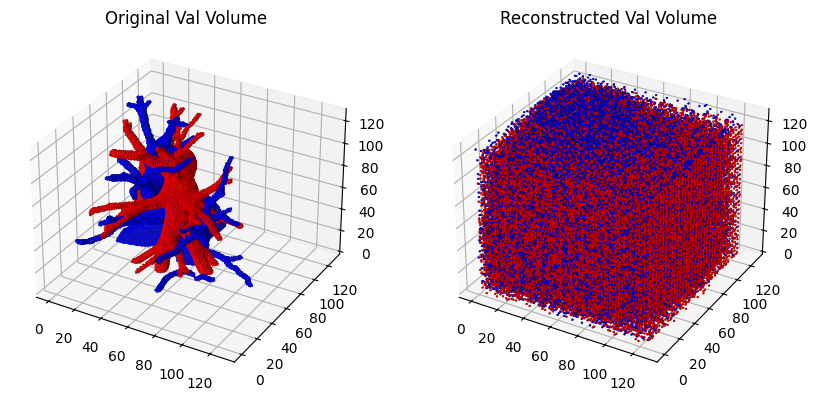

c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/18 [00:00<?, ?it/s] 

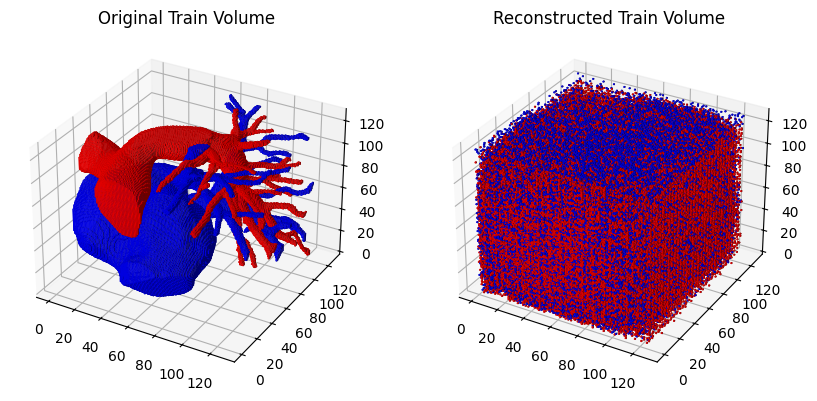

Epoch 0: 100%|██████████| 18/18 [14:29<00:00,  0.02it/s, v_num=27] 

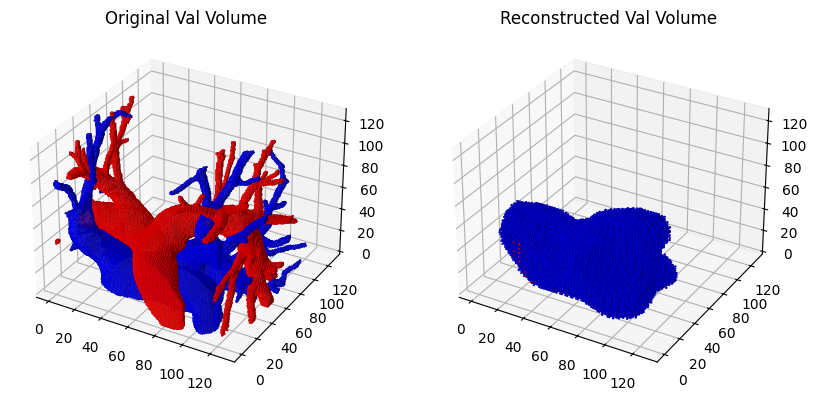

Epoch 300:   0%|          | 0/18 [00:00<?, ?it/s, v_num=27, val_loss=0.0152]         

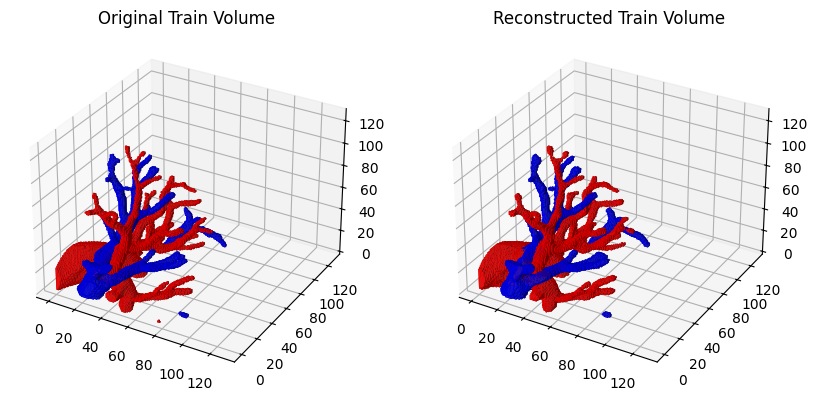

Epoch 300: 100%|██████████| 18/18 [02:24<00:00,  0.12it/s, v_num=27, val_loss=0.0152]

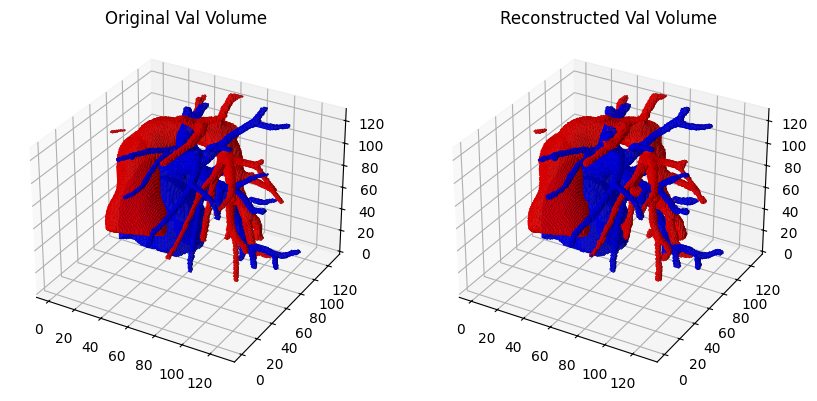

Epoch 600:   0%|          | 0/18 [00:00<?, ?it/s, v_num=27, val_loss=0.00963]         

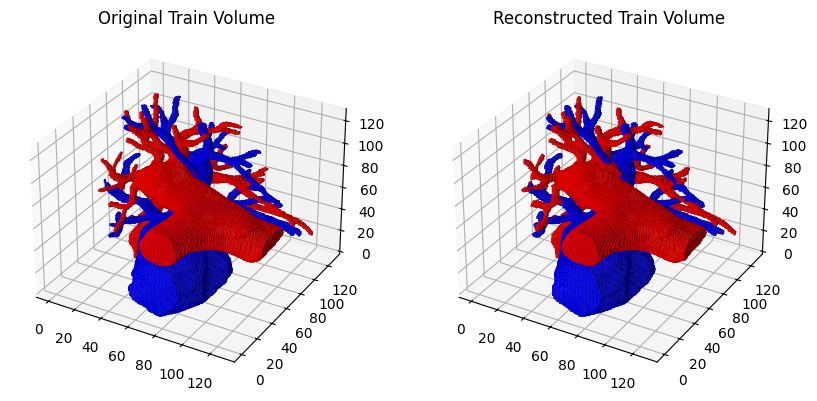

Epoch 600: 100%|██████████| 18/18 [03:28<00:00,  0.09it/s, v_num=27, val_loss=0.00963]

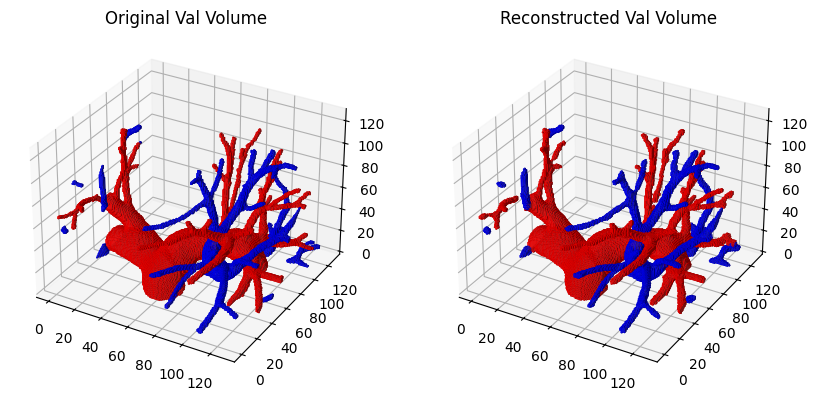

Epoch 900:   0%|          | 0/18 [00:00<?, ?it/s, v_num=27, val_loss=0.00778]         

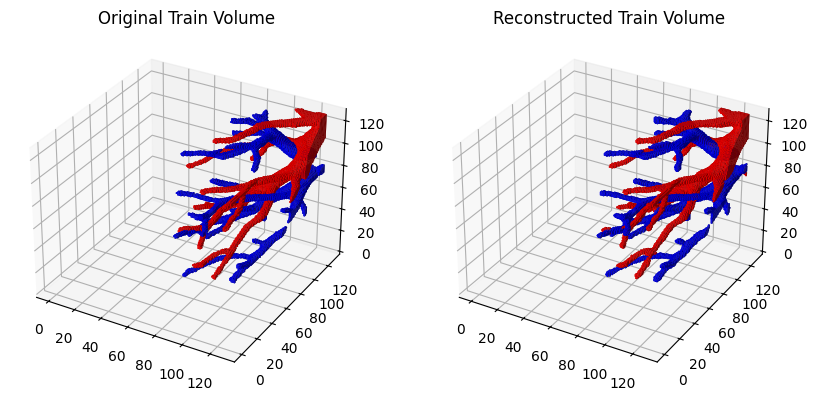

Epoch 900: 100%|██████████| 18/18 [02:22<00:00,  0.13it/s, v_num=27, val_loss=0.00778]

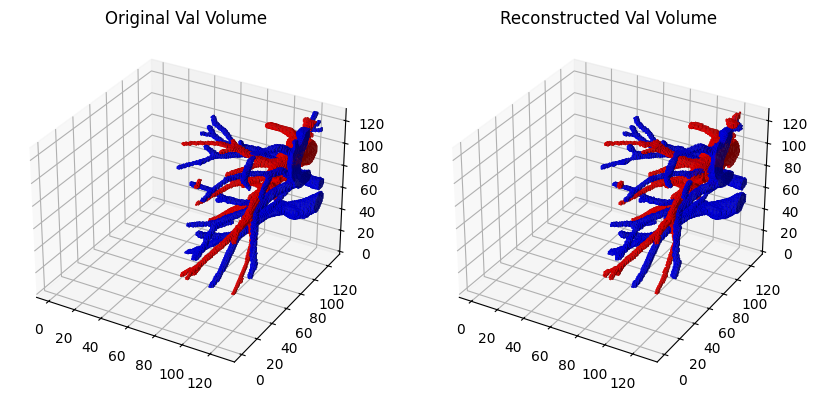

Epoch 1200:   0%|          | 0/18 [00:00<?, ?it/s, v_num=27, val_loss=0.00743]         

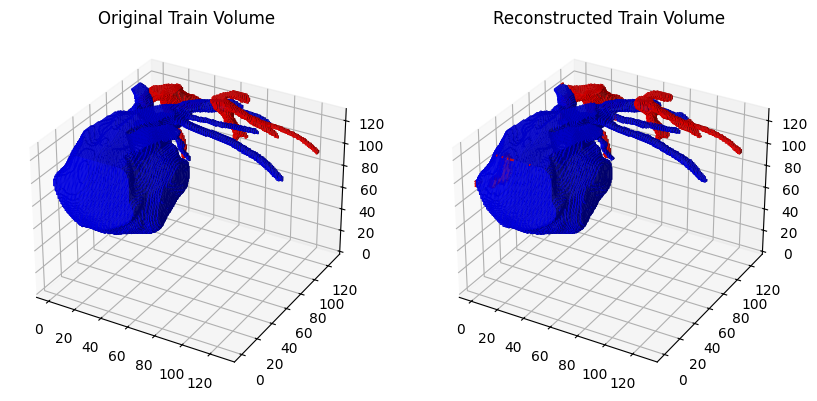

Epoch 1200: 100%|██████████| 18/18 [02:49<00:00,  0.11it/s, v_num=27, val_loss=0.00743]

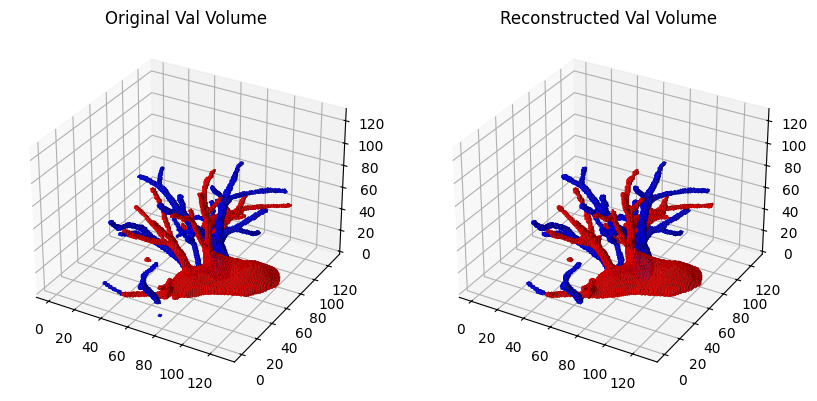

Epoch 1499: 100%|██████████| 18/18 [01:10<00:00,  0.25it/s, v_num=27, val_loss=0.00842]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1499: 100%|██████████| 18/18 [01:11<00:00,  0.25it/s, v_num=27, val_loss=0.00842]


FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  1387598        

In [8]:
# Initialize model and start training
model = AutoEncoderModel()
trainer.fit(model, train_dataloader, val_dataloader)

In [6]:
torch.save(model.state_dict(), "./images/Model/noskips1500.pth")